In [2]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

% matplotlib inline

In [3]:
tabela_final = pd.read_csv('tabela_final_prod.csv')
#tabela_final = pd.read_csv('tabela_final_dev.csv')

In [4]:
columns = [column for column in tabela_final.columns if column != 'municipio']

for column in tabela_final[columns]:
    tabela_final[column] = tabela_final[column].replace('-', np.nan)
    tabela_final[column] = tabela_final[column].astype('float64')

In [5]:
tabela_final = tabela_final.loc[tabela_final.municipio != 'Fernando de Noronha']
#tabela_final = tabela_final.loc[tabela_final.municipio != 'Recife']
#tabela_final = tabela_final.loc[tabela_final.municipio != 'Agua Preta']
# tabela_final = tabela_final.loc[tabela_final.municipio != 'Recife']

for column in tabela_final.columns:
    if 'total' in column:
        tabela_final.drop(column, axis=1, inplace=True)

In [6]:
tabela_final.set_index('municipio',inplace=True)
#tabela_final = tabela_final.fillna(0)

In [7]:
not_in_columns = ['pop','taxa_homicidio','pessoas_de_10_anos_ou_mais_de_idade_ocupadas_na_semana_de_referencia_total',\
                  'domicilios_particulares_permanentes_por_situacao_do_domicilio_rural__destino_do_lixo(%)_coletado',\
                 'domicilios_particulares_permanentes_por_situacao_do_domicilio_rural__destino_do_lixo(%)_queimado_ou_enterrado',\
                 'domicilios_particulares_permanentes_por_situacao_do_domicilio_rural__destino_do_lixo(%)_outra_forma_(1)',\
                 'domicilios_particulares_permanente_por_situacao_do_domicilio_rural__tipo_de_esgotamento_sanitario(%)_rede_geral',\
                 'domicilios_particulares_permanente_por_situacao_do_domicilio_rural__tipo_de_esgotamento_sanitario(%)_fossa_septica',\
                 'domicilios_particulares_permanente_por_situacao_do_domicilio_rural__tipo_de_esgotamento_sanitario(%)_outra_forma_(1)',\
                 'domicilios_particulares_permanente_por_situacao_do_domicilio_rural__sem_instalacao_sanitaria(%)']

In [8]:
which_columns = []
x = tabela_final['taxa_homicidio'].values
for column in tabela_final.columns:
    if (column not in not_in_columns):
        y = tabela_final[column].values
        model = linregress(x,y)
        if (model.pvalue <= 0.0000000000001):
            which_columns.append(column)

In [9]:
#2 0.00000000005
#3 0.00000000006
#4 0.000000000082
#5 0.00000000009
#7 0.0000000001

print(len(which_columns))
which_columns

1


['domicilios_particulares_permanentes_classes_de_salario_minimo_(%)_mais_de_3']

In [10]:
#copiar tabela
tb_signifi = tabela_final

In [11]:
#criando uma nova só com as variaveis que passaram pelo p-value
for column in tb_signifi.columns:
    if (column not in which_columns and column != 'pop' and column != 'taxa_homicidio'):
        tb_signifi = tb_signifi.drop([column],1)

In [12]:
#tb_signifi

In [13]:
#normalizando a tabela
for column in tb_signifi.columns:
    if ('(%)' not in column):
        tb_signifi[column] = tb_signifi[column].apply(lambda x: x * 100000 / tb_signifi['pop'])
        tb_signifi[column] = tb_signifi[column].apply(lambda x: (x - tb_signifi[column].min()) / (tb_signifi[column].max() - tb_signifi[column].min()) ) #normalizacao min-max
        #df[column] = df[column].apply(lambda x: np.log10(x))  
        #df[column] = df[column].apply(lambda x: (x - df[column].mean()) / df[column].std())  #normalizacao zscore
    else:
        tb_signifi[column] = tb_signifi[column].apply(lambda x: x/100)

In [14]:
#tb_signifi

In [15]:
#plotando os graficos
#for column in tb_signifi.columns:
#    if (column != 'pop' and column != 'taxa_homicidio'):
#        plt.subplots(figsize=(8,4))
#        ax = sns.regplot(column, 'taxa_homicidio',data=tb_signifi)

In [16]:
#eliminando as variaveis auxiliares
tb_signifi = tb_signifi.drop(['pop'],1)

In [17]:
#aplicando o cluster
skip_columns = ['taxa_homicidio']
clusterizable_columns = [column for column in tb_signifi.columns if column not in skip_columns]

#df = df.replace([np.inf, -np.inf, '-'], np.nan).dropna()
#model = KMeans(n_clusters=2).fit(tb_signifi.dropna()[clusterizable_columns].values)
model = KMeans(n_clusters=4).fit(tb_signifi.values)
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [18]:
from sklearn.metrics import silhouette_score, silhouette_samples
#print(silhouette_samples(df[['x','y']].values,model.labels_))
print(silhouette_score(tb_signifi[[column,'taxa_homicidio']].values,model.labels_))

0.600522094633


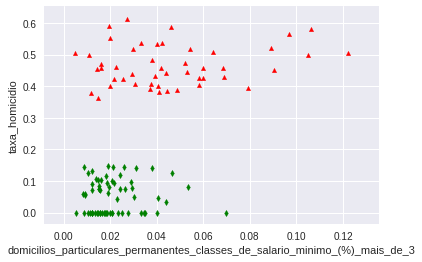

In [19]:
for column in clusterizable_columns:
#for column in tb_signifi:
    clusters = np.asarray(['c{}'.format(a+1) for a in model.labels_],dtype='object')
    ax = tb_signifi.dropna()[clusters=='c1'].plot.scatter(x=column,y='taxa_homicidio',marker='^',color='red')
    tb_signifi.dropna()[clusters=='c2'].plot.scatter(x=column,y='taxa_homicidio',marker='d', color='green',ax=ax)
    #tb_signifi.dropna()[clusters=='c3'].plot.scatter(x=column,y='taxa_homicidio',marker='s',color='magenta', ax=ax)
    #df.dropna()[clusters=='c4'].plot.scatter(x=column,y='taxa_homicidio',marker='*',color='blue', ax=ax)
    # c1, c2, c3 = model.cluster_centers_
    # ax.scatter(*c1,color='red',marker='^',s=50)
    # ax.scatter(*c2,marker='d',color='green',s=50)
    # ax.scatter(*c3,marker='s',color='magenta',s=50)

In [20]:
#clusterizacao
print(model.labels_)

[0 3 1 0 2 0 3 1 3 0 0 3 3 0 1 0 1 3 0 3 0 1 1 3 1 1 1 2 1 3 0 3 1 1 1 1 0
 0 1 0 1 3 3 0 0 1 3 1 1 3 3 1 0 1 2 3 1 0 1 1 1 3 2 1 3 0 0 2 1 0 1 3 3 0
 0 0 3 1 0 1 1 1 3 1 3 3 2 1 3 0 3 0 1 0 0 2 1 1 3 1 3 0 1 3 3 3 0 1 0 3 2
 1 0 3 0 1 1 1 3 1 3 0 3 1 2 0 0 0 3 3 0 2 1 2 3 1 3 3 1 0 3 1 2 1 0 3 1 1
 3 3 1 1 0 3 1 2 3 0 1 3 0 3 3 1 1 3 0 0 3 1 3 0 3 3 1 3 3 1 1 0 1 1 0 3]


In [33]:
#df com o cluster de cada municipio
classes = pd.DataFrame(model.labels_, columns= ["class"])
classes.to_csv('classes.csv')